# Подготовка окружения

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, pipeline
from torch.utils.data import DataLoader
from torch.serialization import add_safe_globals
from configs.config import Config
from src.data_utils import process_dataset, split_dataset
from src.next_token_dataset import TextDataset
from src.lstm_model import LSTMModel, count_parameters, generate_samples
from src.lstm_train import train_model
from src.eval_lstm import calculate_rouge_lstm
from src.eval_transformer_pipeline import calculate_rouge_transformer

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
IS_TEST = True # тестовый сценарий для отладки кода на слабой машине
config = Config(is_test=IS_TEST) # конфигурационные параметры

tokenizer = AutoTokenizer.from_pretrained(config.tokenizer_name)
tokenizer.pad_token = tokenizer.pad_token or tokenizer.eos_token

config.pad_token_id = tokenizer.pad_token_id or tokenizer.eos_token_id
config.pad_token = tokenizer.pad_token
config.vocab_size = len(tokenizer)

print(f'вычисления на {config.device}\n')
print('\n параметры запуска')
vars(config)

вычисления на cuda


 параметры запуска


{'raw_ds_path': './data/raw_dataset.txt',
 'ds_processed_path': './data/dataset_processed.txt',
 'ds_train_path': './data/train.csv',
 'ds_val_path': './data/val.csv',
 'ds_test_path': './data/test.csv',
 'model_path': './models/lstm_model.pth',
 'max_raw__ds_length': 100,
 'batch_size': 16,
 'embedding_dim': 256,
 'hidden_dim': 128,
 'num_layers': 1,
 'dropout': 0.3,
 'learning_rate': 0.002,
 'num_epochs': 10,
 'max_length': 64,
 'train_val_split': 0.8,
 'text_split_on_prediction': 0.75,
 'device': 'cuda',
 'tokenizer_name': 'distilgpt2',
 'pad_token_id': 50256,
 'pad_token': '<|endoftext|>',
 'vocab_size': 50257}

# Подготовка датасета

### 1. Получение и очистка исходных текстов

In [3]:
file = config.raw_ds_path
if not os.path.exists(file):
    !wget https://code.s3.yandex.net/deep-learning/tweets.txt -O {file}


количество текстов: 100

статистика количества слов в тексте:
         мин: 3
     медиана: 14.00
     среднее: 13.59
        макс: 27
 5-й перц-ль: 3.95
95-й перц-ль: 24.05


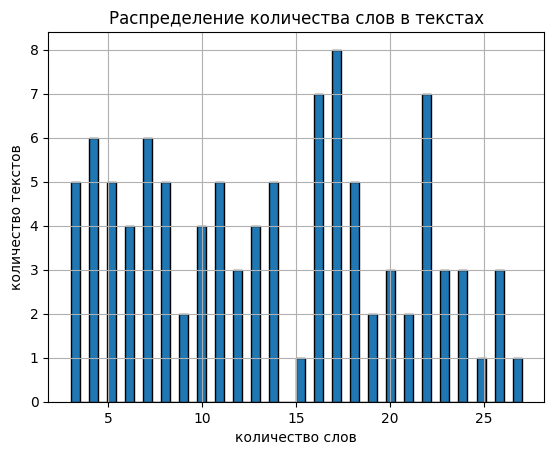


примеры чистых текстов:

www that s a bummer ou shoulda got avid arr of hird ay to do it
is upset that he can t update his acebook by texting it and might cry as a result chool today also lah
dived many times for the ball anaged to save 50 he rest go out of bounds
my whole body feels itchy and like its on fire
no it s not behaving at all i m mad why am i here because can t see you all over there


In [4]:
clean_corpus = process_dataset(config)

### 2. Разделение датасета на подсеты с сохранением в файлы 

In [5]:
train_texts, val_texts, test_texts = split_dataset(texts=clean_corpus,config=config)

# Подготовка Dataloaders

### 1. Инициализация Datasets

In [20]:
train_dataset = TextDataset(train_texts, tokenizer, config)
val_dataset = TextDataset(val_texts, tokenizer, config)
test_dataset = TextDataset(test_texts, tokenizer, config)

print(f'\ntrain_dataset len:', f"{len(train_dataset):_}")
print(f'val_dataset len:  ', f"{len(val_dataset):_}")
print(f'test_dataset len: ', f"{len(test_dataset):_}")


train_dataset len: 80
val_dataset len:   10
test_dataset len:  10


### 2. Инициализация Dataloaders

In [7]:
dl_config = {
    'batch_size': config.batch_size,
    'num_workers': 4,
    'pin_memory': config.device=='cuda',
    'persistent_workers': True,
    'prefetch_factor': 2,
}

train_dataloader = DataLoader(train_dataset, **dl_config, shuffle=True)
val_dataloader = DataLoader(val_dataset, **dl_config, shuffle=False)
test_dataloader = DataLoader(test_dataset, **dl_config, shuffle=False)

print(f'батчей в train: {len(train_dataloader)}')
print(f'батчей в val:   {len(val_dataloader)}')
print(f'батчей в test:  {len(test_dataloader)}')

батчей в train: 5
батчей в val:   1
батчей в test:  1


# Обучение модели

### Инициализация модели

In [8]:
model = LSTMModel(config)
print('количество параметров: ', f'{count_parameters(model):_}')
model = model.to(config.device)

количество параметров:  19_546_577


In [9]:
criterion = nn.CrossEntropyLoss(ignore_index=config.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

### Обучение и валидация

Модель на cuda:0


         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, rouge1 max=0.0000]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.25 GB
max per epoch: 1.00 GB
=====>GPU 0
  train loss: 10.8170, val loss: 10.8037
  val rouge1: 0.0000, val rouge2: 0.0000
-------------------- end of epoch 1/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, rouge1 max=0.0000]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.25 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 10.6140, val loss: 10.7470
  val rouge1: 0.0000, val rouge2: 0.0000
-------------------- end of epoch 2/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, rouge1 max=0.0000]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 10.3197, val loss: 10.5726
  val rouge1: 0.0000, val rouge2: 0.0000
-------------------- end of epoch 3/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, rouge1 max=0.0488]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 9.5315, val loss: 9.6175
  val rouge1: 0.0049, val rouge2: 0.0000
-------------------- end of epoch 4/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, rouge1 max=0.0870]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 7.7684, val loss: 8.7068
  val rouge1: 0.0258, val rouge2: 0.0000
-------------------- end of epoch 5/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, rouge1 max=0.0851]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 6.6417, val loss: 8.8673
  val rouge1: 0.0310, val rouge2: 0.0000
-------------------- end of epoch 6/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, rouge1 max=0.0889]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 6.2377, val loss: 9.1506
  val rouge1: 0.0394, val rouge2: 0.0000
-------------------- end of epoch 7/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, rouge1 max=0.0444]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 6.0243, val loss: 9.3706
  val rouge1: 0.0285, val rouge2: 0.0000
-------------------- end of epoch 8/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, rouge1 max=0.0800]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 5.9350, val loss: 9.5279
  val rouge1: 0.0313, val rouge2: 0.0000
-------------------- end of epoch 9/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, rouge1 max=0.0800]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 5.8339, val loss: 9.6535
  val rouge1: 0.0314, val rouge2: 0.0000
-------------------- end of epoch 10/10 -------------------- 



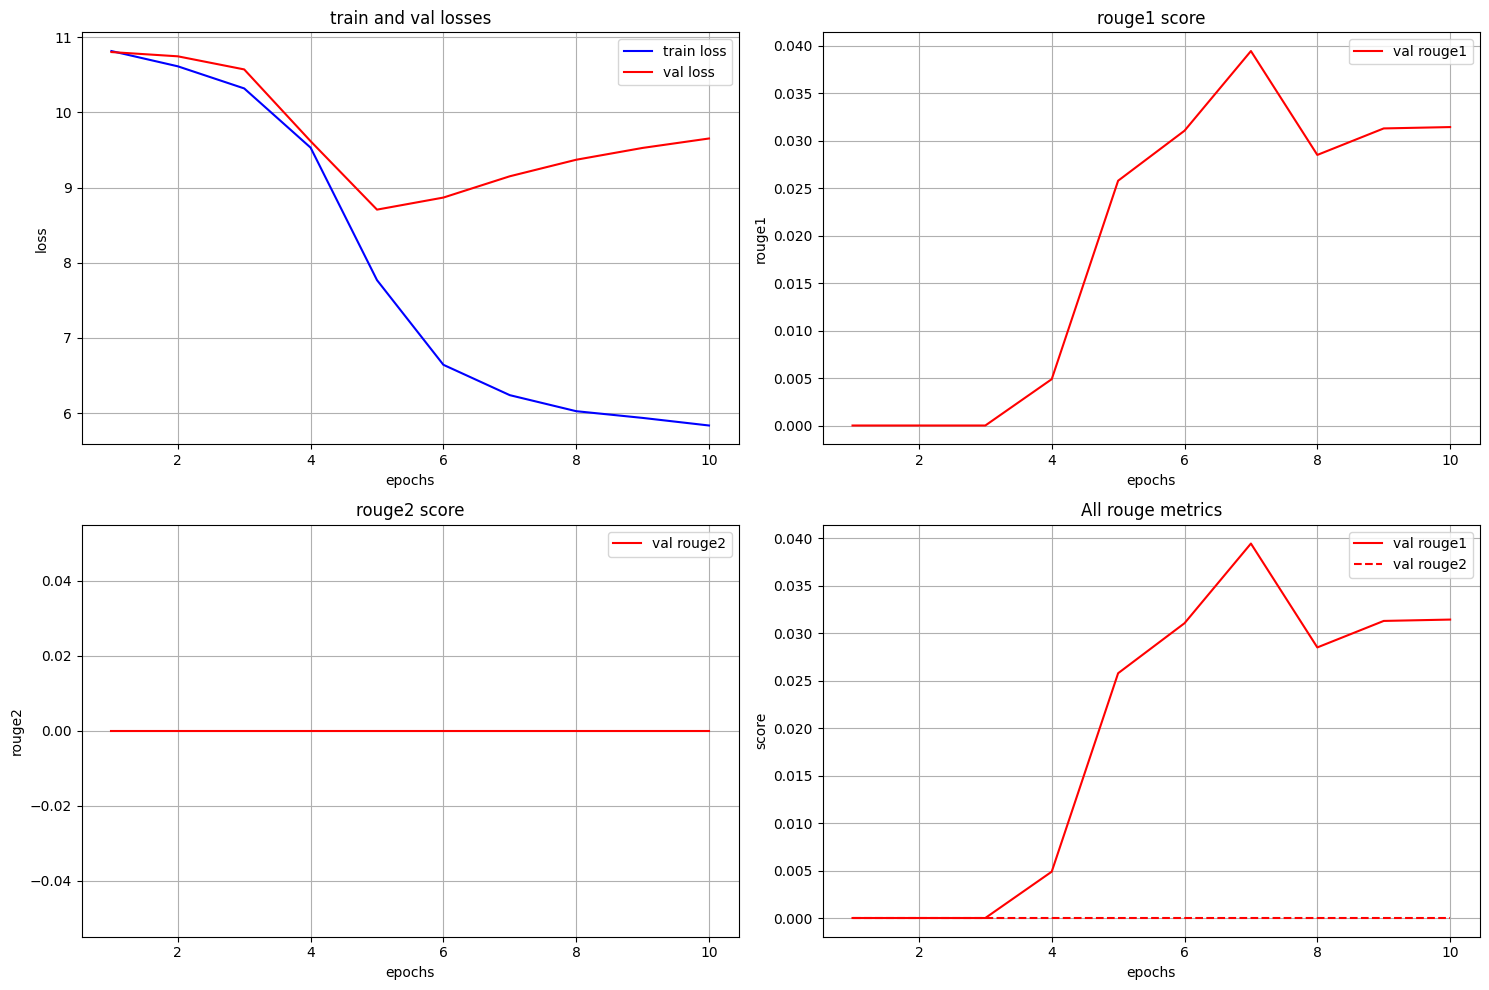

In [10]:
train_model(
    model,
    tokenizer,
    config,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
)

### Сохранение модели

In [11]:
torch.save({
        'model_state_dict': model.state_dict(),
        'config': config,
    }, config.model_path
    )

### Загрузка модели

In [12]:
add_safe_globals([Config])
checkpoint = torch.load(config.model_path, map_location=config.device)
model = LSTMModel(checkpoint["config"]).to(config.device)

model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

LSTMModel(
  (embedding): Embedding(50257, 256, padding_idx=50256)
  (lstm): LSTM(256, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=50257, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

### Генерация дополнения текстов

In [ ]:
samples = random.sample(test_texts, 6) # 6 рримеров
generate_samples(model, tokenizer, config, samples)

asis:       y donkey is sensitive about such comments evertheless he d and me d be glad to see your  ->  mug asap harger is still awol
generated:  y donkey is sensitive about such comments evertheless he d and me d be glad to see your  ->   t as with 4 esalemor sn can isleyyle massive w sleep only here got waiting on hug citrus don premiere texting can feeling com iron know hates like t the much you out likeian you it part my idanking o ones have my s my work he are u arms show music s sleep bitst alley you
rouge1: 0.0000,   rouge2: 0.0000

asis:       couldn t bear to watch it nd thought the  ->  loss was embarrassing
generated:  couldn t bear to watch it nd thought the  ->   wage afternoon illnt and is to to to my ar sleep puppy to w sd when location citrus  part much chicken to sick good want how sd doing how enough teams not r get l ut meeting of and te sorryy sleep tomorrowah sick pro the boo trade ones may he and drinking will break sorry now really unbelievableigo
rouge1: 0.0000

### Метрики rouge модели на тестовой выборке

In [14]:
print('----модель lstm---------')
print('\nколичество параметров: ', f"{count_parameters(model):_}", '\n')
print('\nтекстов в выборке: ', f"{len(test_texts):_}", '\n')

test_dataloader = DataLoader(test_dataset, **dl_config, shuffle=False)

r1, r2 = calculate_rouge_lstm(
    model, test_dataloader, tokenizer, config, prefix="test"
)
print(f"\ntest rouge1: {r1:.4f}, test rouge2: {r2:.4f}")
print('-'*40)

----модель lstm---------

количество параметров:  19_546_577 


текстов в выборке:  10 



         сalc rouge metrics test: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, rouge1 max=0.1200]


test rouge1: 0.0395, test rouge2: 0.0000
----------------------------------------


# Сравнение с трансформером и выводы

### Метрики rouge трансформера на тестовой выборке

In [ ]:
print('----модель distilgpt2---------')
generator = pipeline("text-generation", model="distilgpt2", device=config.device)
print('\nколичество параметров: ', f"{count_parameters(generator.model):_}", '\n')
print('\nтекстов в выборке: ', f"{len(test_texts):_}", '\n')
r1,r2 = calculate_rouge_transformer(generator, config, test_texts)
print(f"\ntest rouge1: {r1:.4f}, test rouge2: {r2:.4f}")
print('-'*40)

----модель distilgpt2---------


Device set to use cuda



количество параметров:  81_912_576 


текстов в выборке:  10 



         сalc rouge metrics test: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s, rouge1 max=0.1739]


test rouge1: 0.0356, test rouge2: 0.0000
